Decision Tree Act Math with proficent score as label

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix,f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
actMath_11_df = pd.read_csv('../dataframes/actMath_11.csv')


In [3]:
actMath_11_df.head(10)

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course

PCA

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actMath_11_df.drop(['proficient_score', 'studentId', 'is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")

Number of components needed: 107
Cumulative explained variance: 0.8008010473434182


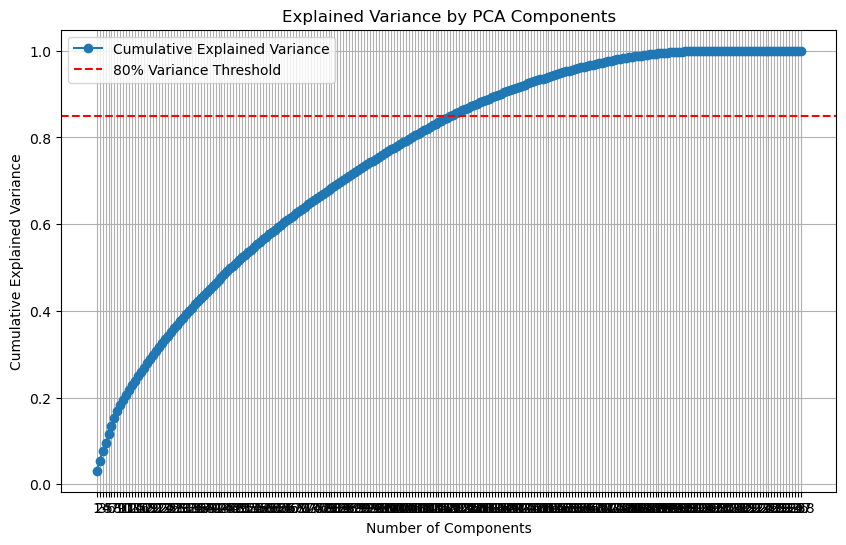

Number of components needed: 107


In [5]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [6]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_108_pcs_df = X_pca_df.iloc[:, :108].copy()
#first_108_pcs_df

In [7]:
print(pca.components_.shape)
print(actMath_11_df.columns)

cols_drop = ['studentId', 'is_proficient', 'proficient_score']
columns_to_drop = [col for col in cols_drop if col in actMath_11_df.columns]
feature_names = actMath_11_df.drop(columns=columns_to_drop).columns

(238, 238)
Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)


In [8]:
components = pca.components_[:108]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component           Top Feature
0                   PC1    course_HEALTH 9-12
1                   PC1     course_DRIVERS ED
2                   PC1  school_High School B
3                   PC1    course_D&TSafetyEd
4                   PC1    course_Health 9-12
5                   PC2   course_Physical Sci
6                   PC2   course_English Gr10
7                   PC2    course_Algebra I B
8                   PC2    course_USHis I G10
9                   PC2    course_US His-1877
10                  PC3   course_Eng Gr10 Adv
11                  PC3   course_ChemistryAdv
12                  PC3    course_USHis I Adv
13                  PC3   course_HS US 10 ADV
14                  PC3    course_D&TSafetyEd
15                  PC4   course_Ess II:USHis
16                  PC4   course_Ess: Phy Sci
17                  PC4     course_Eng Ess 10
18                  PC4   course_Alg Esntls B
19                  PC4    course_RdIntrv7-12
20                  PC5   course_E

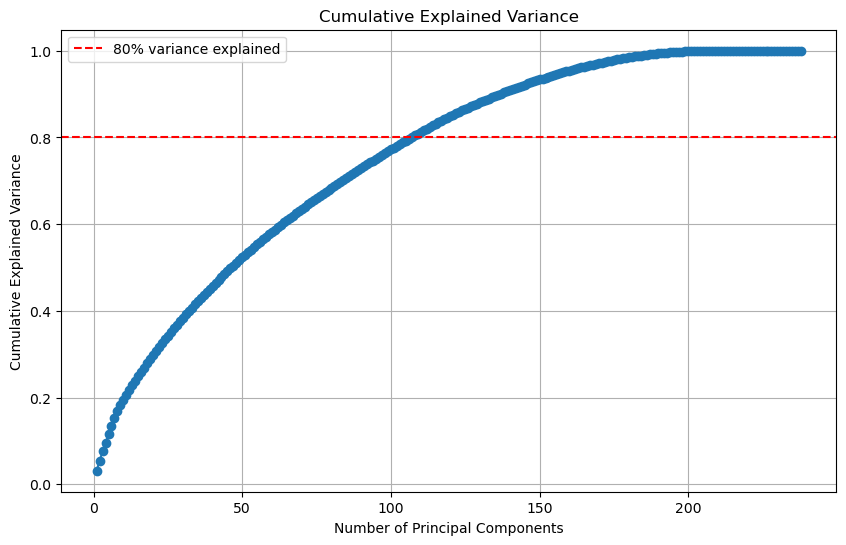

In [9]:
# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Training on PCA

In [10]:
X_PCA = first_108_pcs_df  # PCA-transformed features
y_PCA = actMath_11_df['proficient_score']
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.20, random_state=123)
print(X_train_PCA.shape)

(2064, 108)


In [11]:
'''
max_depth_values= [8,12,25,32]
min_samples_leaf_values = [4,5,8,10]
param_grid = {'max_depth' : list(max_depth_values), 'min_samples_leaf' : list(min_samples_leaf_values)}


#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressor_PCA = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid_PCA = GridSearchCV(dt_regressor_PCA, param_grid, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search_PCA = dt_grid_PCA.fit(X_train_PCA, y_train_PCA)

print("Done")
dt_best_params_PCA = dt_grid_search_PCA.best_params_

dt_best_params_PCA
'''
#{'max_depth': 32, 'min_samples_leaf': 5}


'\nmax_depth_values= [8,12,25,32]\nmin_samples_leaf_values = [4,5,8,10]\nparam_grid = {\'max_depth\' : list(max_depth_values), \'min_samples_leaf\' : list(min_samples_leaf_values)}\n\n\n#Grid Search to find the best hyperparameters \nprint("Running Grid Search")\ndt_regressor_PCA = DecisionTreeRegressor()\n\n# will have a 3-fold cross validation \ndt_grid_PCA = GridSearchCV(dt_regressor_PCA, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\ndt_grid_search_PCA = dt_grid_PCA.fit(X_train_PCA, y_train_PCA)\n\nprint("Done")\ndt_best_params_PCA = dt_grid_search_PCA.best_params_\n\ndt_best_params_PCA\n'

Metrics PCA

In [12]:
dt_model_PCA = DecisionTreeRegressor(max_depth=32, min_samples_leaf=5)
dt_model_PCA.fit(X_train_PCA,y_train_PCA)

#testing model on the X_test
y_dt_pred_PCA = dt_model_PCA.predict(X_test_PCA)
dt_rmse_PCA = mean_squared_error(y_test_PCA,y_dt_pred_PCA,squared=False)
dt_r2_PCA = r2_score(y_test_PCA,y_dt_pred_PCA)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_bool_PCA = y_dt_pred_PCA >= threshold
y_test_bool_PCA = y_test_PCA >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool_PCA, y_pred_bool_PCA))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse_PCA))
print('[DT] R2: {0}'.format(dt_r2_PCA))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.95      0.85       319
        True       0.88      0.53      0.66       197

    accuracy                           0.79       516
   macro avg       0.82      0.74      0.76       516
weighted avg       0.81      0.79      0.78       516

[DT] Root Mean Squared Error: 0.18801667562469626
[DT] R2: 0.3532448095808576


In [13]:
micro_f1_PCA = f1_score(y_test_bool_PCA, y_pred_bool_PCA, average='micro')

print("Micro F1 Score:", micro_f1_PCA)

Micro F1 Score: 0.7926356589147286


In [14]:
actMath_11_df.dtypes

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
course_ACTReview.5C        bool
course_AG Communica        bool
course_AIDE-ELEM           bool
course_AIDE-LIB            bool
course_ALG I B ACCE        bool
course_ALIITRIGH/A         bool
course_ARMY LET I          bool
course_ARMY LET II         bool
course_ARMY LET III        bool
course_ARMY LET IV         bool
course_ARMYLETIVACT        bool
course_AcAdv.Baseba        bool
course_AcAdv.Basket        bool
course_AcAdv.CrossC        bool
course_AcAdv.Footb         bool
course_AcAdv.Softba        bool
course_AcAdv.Volley        bool
course_Accounting          bool
course_Adv BTA             bool
course_Advanced Agr        bool
course_Agriscience         bool
course_Alg Esntls B        bool
course_Alg II/Trig         bool
course_AlgEnrichmet        bool
course_AlgII/TrigAC        bool
course_Algebra I           bool
course_A

In [15]:
actMath_11_df[actMath_11_df.select_dtypes(include=['bool']).columns] = actMath_11_df.select_dtypes(include=['bool']).astype(int)
actMath_11_df.dtypes

studentId                 int64
is_proficient             int32
proficient_score        float64
course_ACT Review         int32
course_ACT/WK Rev.        int32
course_ACTReview.5C       int32
course_AG Communica       int32
course_AIDE-ELEM          int32
course_AIDE-LIB           int32
course_ALG I B ACCE       int32
course_ALIITRIGH/A        int32
course_ARMY LET I         int32
course_ARMY LET II        int32
course_ARMY LET III       int32
course_ARMY LET IV        int32
course_ARMYLETIVACT       int32
course_AcAdv.Baseba       int32
course_AcAdv.Basket       int32
course_AcAdv.CrossC       int32
course_AcAdv.Footb        int32
course_AcAdv.Softba       int32
course_AcAdv.Volley       int32
course_Accounting         int32
course_Adv BTA            int32
course_Advanced Agr       int32
course_Agriscience        int32
course_Alg Esntls B       int32
course_Alg II/Trig        int32
course_AlgEnrichmet       int32
course_AlgII/TrigAC       int32
course_Algebra I          int32
course_A

In [16]:

#training 
y = actMath_11_df['proficient_score']
X= actMath_11_df.drop(['proficient_score', 'studentId','is_proficient'], axis=1)
print("Number of examples: " + str(X.shape[0]))

X_train,X_test, y_train,y_test= train_test_split(X,y, test_size=0.20, stratify = actMath_11_df['is_proficient'],random_state=123)
print(X_train.shape)
print(X_test.shape)

Number of examples: 2580
(2064, 238)
(516, 238)


In [17]:
#possible hyperparameters
max_depth_values= [8,12,25,32]
min_samples_leaf_values = [4,5,8,10]
param_grid = {'max_depth' : list(max_depth_values), 'min_samples_leaf' : list(min_samples_leaf_values)}


#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressor = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search = dt_grid.fit(X_train, y_train)

print("Done")
dt_best_params = dt_grid_search.best_params_

dt_best_params
#{'max_depth': 25, 'min_samples_leaf': 4}

Running Grid Search
Done


{'max_depth': 25, 'min_samples_leaf': 10}

In [18]:
dt_model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=10)
dt_model.fit(X_train,y_train)

#testing model on the X_test
y_dt_pred = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test,y_dt_pred,squared=False)
dt_r2 = r2_score(y_test,y_dt_pred)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_bool = y_dt_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.92      0.84       329
        True       0.78      0.51      0.62       187

    accuracy                           0.77       516
   macro avg       0.77      0.72      0.73       516
weighted avg       0.77      0.77      0.76       516

[DT] Root Mean Squared Error: 0.19591858450696217
[DT] R2: 0.3285939154210935


In [19]:
micro_f1 = f1_score(y_test_bool, y_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7713178294573645


Confusion Matrix:
[[302  27]
 [ 91  96]]


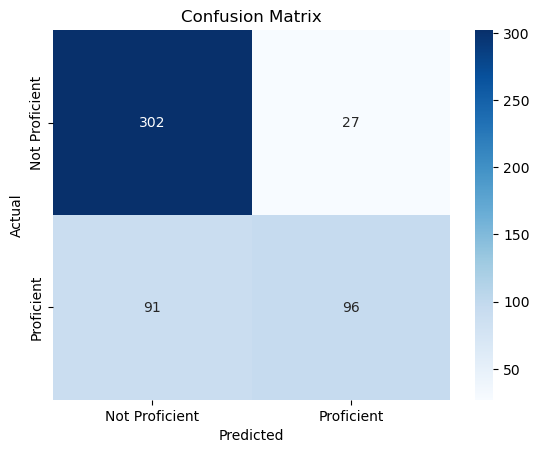

In [20]:
cm = confusion_matrix(y_test_bool, y_pred_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

In [21]:
importances = dt_model.feature_importances_
feature_names = X_train.columns

# Combine names and importances, and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

                  Feature  Importance
58    course_ChemistryAdv    0.505452
84      course_Enviro Sci    0.086371
156    course_Phy Sci Adv    0.052909
29     course_Algebra I B    0.037233
46      course_BullBogAdv    0.029482
23    course_Alg Esntls B    0.021487
218     course_VisArtI.5C    0.020173
40    course_BandConcer.5    0.019815
7      course_ALIITRIGH/A    0.015229
24     course_Alg II/Trig    0.015215
113    course_Health 9-12    0.015075
196    course_US His-1877    0.013439
200    course_USHis InD-P    0.012108
183   course_StudyHall912    0.010276
132   course_LIFEPE9-12.5    0.010222
189   course_TmSpts-Dance    0.008056
76    course_Eng Gr10 Adv    0.008009
105   course_Geometry Adv    0.007657
56    course_CareerPrep-B    0.007650
61    course_ContempIss1C    0.007505
131   course_LIFE PE 9-12    0.007139
68      course_DRIVERS ED    0.007131
198    course_USHis I Adv    0.006356
96    course_Food Nutritn    0.005866
231  school_High School A    0.005792
177      cou